In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from datetime import timedelta
from timeit import default_timer as timer
from math import sqrt

## Images reading&resizing

In [2]:
img_l = np.asanyarray(Image.open("i1.jpg").resize((400,300), Image.BICUBIC).convert("RGB")).astype(np.int)
img_r = np.asanyarray(Image.open("i2.jpg").resize((400,300), Image.BICUBIC).convert("RGB")).astype(np.int)

## Params definition

In [3]:
kg_max=45
kv_max=14
kv_half = kv_max//2
height = img_r.shape[0]
length = img_r.shape[1]

In [4]:
#import shelve

In [5]:
#with shelve.open("lab2.db") as db:
    #db["img_shift2"] = img_shift2
    #img_shift2 = db["img_shift2"]

In [6]:
#np.save("img_shift.npy", img_shift2)

In [72]:
img_shift2 = np.load("img_shift.npy")

In [8]:
from scipy import ndimage

In [ ]:
#k = np.ones((3,3))/9
#img_shift2[:,:,0] = ndimage.convolve(img_shift2[:,:,0], k, mode='reflect')
#img_shift2[:,:,1] = ndimage.convolve(img_shift2[:,:,1], k, mode='reflect')
#Image.fromarray((255.9*img_shift2/img_shift2.max()).astype(np.uint8))

# lab2 start

https://staff.fnwi.uva.nl/l.dorst/hz/chap11_13.pdf

In [73]:
from random import choices
from scipy.linalg import null_space

In [95]:
def is_smooth(img_shift, x, y):
    start = -3
    end = 3
    for i in range(start,end+1):
        for j in range(start,end+1):
            if img_shift[y, x, 0] != img_shift[y+i, x+j, 0] or img_shift[y, x, 1] != img_shift[y+i, x+j, 1]:
                return False
    return True

In [97]:
pairs = []
rejected_pairs = []
# (X, X')
for y in range(30, img_r.shape[0] - 30):
    for x in range(30, img_r.shape[1] - 30):
        x_norm = [x, y, 1]
        dot_shift = img_shift2[y, x]
        
        x2 = int(x + dot_shift[0])
        y2 = int(y + dot_shift[1] - kv_half)
        x_strich = [x2, y2, 1]
        
        if is_smooth(img_shift2, x, y):
            pairs.append([x_norm, x_strich])
        else:
            rejected_pairs.append([x_norm, x_strich])

In [141]:
len(pairs)

13982

In [142]:
len(rejected_pairs)

67618

In [125]:
Boundary = 0.01
bestF = None
bestScore = 0

a_2 = np.array([i[0] for i in pairs])
b_2 = np.array([i[1] for i in pairs])

for iteration in range(20000):
    #print(iteration, end=" ")
    seven_pairs = choices(pairs, k=7)
    X_big = []
    for a,b in seven_pairs:
        x1, y1, z1 = a
        x2, y2, z2 = b
        X_big.append([x2*x1, x2*y1, x2*z1, y2*x1, y2*y1, y2*z1, z2*x1, z2*y1, z2*z1])
        # на попередній лінії була помилка,
        # через яку я декілька тижнів не міг зрозуміти чого не працює.
        # вічна пам'ять моїм загиблим нервовим клітинам.
        # F
    X_big = np.array(X_big)
    null_vectors = null_space(X_big)
    f1 = null_vectors[:,0].reshape((3,3))
    f2 = null_vectors[:,1].reshape((3,3))
    
    p = np.array([np.linalg.det(f2),
     np.linalg.det(f2)*np.trace(np.dot(np.linalg.inv(f2), f1)),
     np.linalg.det(f1)*np.trace(np.dot(np.linalg.inv(f1), f2)),
     np.linalg.det(f2),
    ])
    coefs = np.roots(p)
    for i in coefs[:1]:
        if np.iscomplex(i):
            continue
        F = f1+i*f2
        # both matrix have zero det
        score = np.sum(np.abs(np.einsum('ki,ij,kj->k', b_2, F, a_2)) < Boundary)
        if score > bestScore:
            bestScore = score
            bestF = F.copy()
            print("="*20)
            print("hit", bestScore/len(pairs))
            
            epipole = null_space(bestF, 1e-3)
            epipole = epipole/epipole[-1]
            epipole_strich = [epipole[0,0], epipole[1,0]]
            print("X:", epipole_strich[0])
            print("Y:", epipole_strich[1])

hit 0.0034329852667715635
X: 266.24770514045537
Y: 198.0860605272342
hit 0.03661850951223001
X: 271.3730211216899
Y: -253.5216937439826
hit 0.12094121012730653
X: (253.11650215826077+0j)
Y: (141.15566798305727+0j)
hit 0.16757259333428695
X: 285.23747842697423
Y: 123.52533430113336
hit 0.19196109283364327
X: (344.24909173063094+0j)
Y: (98.55196963621148+0j)
hit 0.27585467029037336
X: 221.38695602953769
Y: 247.21687480161768
hit 0.3069660992704906
X: 111.9112593654043
Y: 36071.677275215494


## Фундаментальна матриця

In [126]:
np.round(bestF, 1)

array([[ -0. ,  -0. ,   2.6],
       [  0. ,   0. ,  -0. ],
       [ -2.6,   0. , -20.8]])

In [127]:
bestF

array([[-9.23070461e-07, -7.20346334e-05,  2.59871516e+00],
       [ 7.38500935e-05,  1.58429825e-06, -8.64935613e-03],
       [-2.59872558e+00,  8.63778070e-03, -2.07525841e+01]])

In [130]:
np.save("bestF.npy", bestF)
np.save("bestScore.npy", bestScore)

In [131]:
#bestF = np.load("bestF.npy")
#bestScore = np.load("bestScore.npy")

In [132]:
#with shelve.open("lab2.db") as db:
#    #db["bestF"] = bestF
#    #db["bestScore"] = bestScore
#    bestF = db["bestF"]
#    bestScore = db["bestScore"]
#    #img_shift2 = db["img_shift2"]

## Відсоток точок, які задовольняють умову до фундаментальної матриці

In [133]:
print(round(100*bestScore/len(pairs), 2),"%")

30.7 %


## Епіполярна точка у 3-х координатах

In [134]:
epipole = null_space(bestF, 1e-3)
epipole = epipole/epipole[-1]
epipole

array([[1.11911259e+02],
       [3.60716773e+04],
       [1.00000000e+00]])

In [135]:
np.linalg.det(bestF)

1.062745771186183e-05

In [136]:
epipole_strich = [epipole[0,0], epipole[1,0]]

## Епіполярна точка

In [137]:
print("X:", epipole_strich[0])
print("Y:", epipole_strich[1])

X: 111.9112593654043
Y: 36071.677275215494


## Ліве зображення

In [138]:
from PIL import ImageDraw

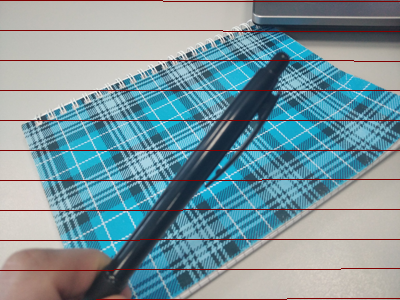

In [139]:
image2show = Image.open("i1.jpg").resize((400,300), Image.BICUBIC).convert("RGB")
draw = ImageDraw.Draw(image2show)
for i in range(11):
    draw.line((0, i*30, epipole_strich[1], epipole_strich[0]), fill=128)
image2show

## Праве зображення

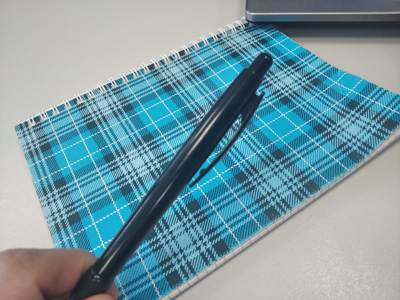

In [140]:
Image.open("i2.jpg").resize((400,300), Image.BICUBIC).convert("RGB")